# SQLAlchemy Homework - Surfs Up!

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

# Base.metadata.tables

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# print columns of the measurement table

inspector = inspect(engine)

cols = inspector.get_columns('Measurement')
for col in cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# print columns of the station table
cols = inspector.get_columns('Station')
for col in cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# acquiring the last date of the data point

last_date_sel = ["Select date From Measurement Group By date Order By date Desc"]
last_date = engine.execute(*last_date_sel).fetchone()

In [11]:
# design a query to retrieve the last 12 months of precipitation data and plot the results

# determining date of last 12 month date from data point

last_12m_date = dt.datetime.strptime(last_date[0],"%Y-%m-%d") - dt.timedelta(days = 365)

# query to retrieve precipitation data in the last 12 months (grouped by month)

precip_by_month = session.query(func.strftime("%m",Measurement.date), func.sum(Measurement.prcp)).\
                    group_by(func.strftime("%m",Measurement.date)).\
                    filter(Measurement.date >= last_12m_date)

In [12]:
# converting to dataframe

precip_by_month_df = pd.DataFrame(precip_by_month,columns={'month':precip_by_month[0],'prcp':precip_by_month[1]})
precip_by_month_df.head()

,month,prcp
0,01,11.95
1,02,39.06
2,03,29.62
3,04,54.91
4,05,25.27


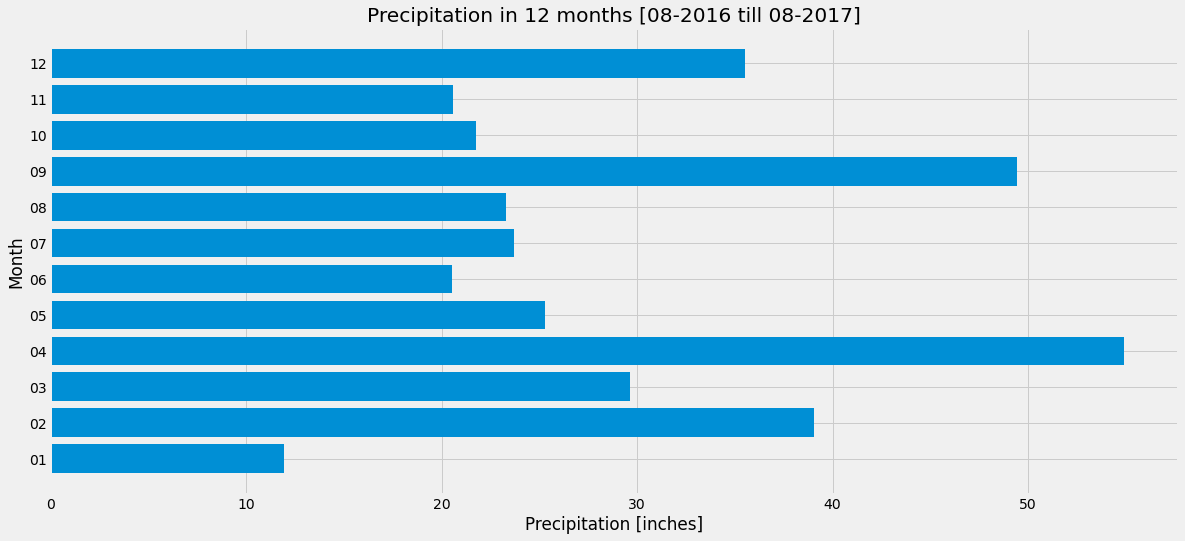

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
# plotting precipitation data in the last 12 months

# setting figure size

plt.figure(figsize=(18,8));

# defining horizontal bar chart

plt.barh(precip_by_month_df.month, precip_by_month_df.prcp)

# setting title & labels
plt.xlabel('Precipitation [inches]')
plt.ylabel('Month')
plt.title('Precipitation in 12 months [08-2016 till 08-2017]')
plt.grid(True);

#plt.savefig('Images/precipitation_by_month.png')

# displaying the chart
plt.show()

In [14]:
# Calculate the date 1 year ago from the last data point in the database

# retrieving last date data point from given dataset

last_date_sel = ["Select date From Measurement Group By date Order By date Desc"]
last_date = engine.execute(*last_date_sel).fetchone()

one_year_ago = dt.datetime.strptime(last_date[0], "%Y-%m-%d") - dt.timedelta(days = 365)

print('--------------------------------------------------------')
print(f' The date 1 year ago from the data point is {one_year_ago.strftime("%Y-%m-%d")}.')
print('---------------------------------------------------------')

--------------------------------------------------------
 The date 1 year ago from the data point is 2016-08-23.
---------------------------------------------------------


In [15]:
# Perform a query to retrieve the data and precipitation scores

# retrieving precipitation data in the last 12 month (by date), ordering by date

data = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date >= last_12m_date).\
                        group_by(Measurement.date)

# verifying data returning from query
for row in data.limit(5):
    print(row)

('2016-08-24', 0.08)
('2016-08-25', 0.08)
('2016-08-26', 0.0)
('2016-08-27', 0.0)
('2016-08-28', 0.01)


In [16]:
# save the query results as a Pandas DataFrame and set the index to the date column
# sort the dataframe by date

measure_df = pd.DataFrame(data, columns=['Date', 'Precipitation']).sort_values('Date').set_index('Date')

# removing NaN values in the dataset
measure_df = measure_df.dropna()

# reseting index
measure_df.reset_index(inplace=True)

# Use Pandas to calcualte the summary statistics for the precipitation data
measure_df.describe()

,Precipitation
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


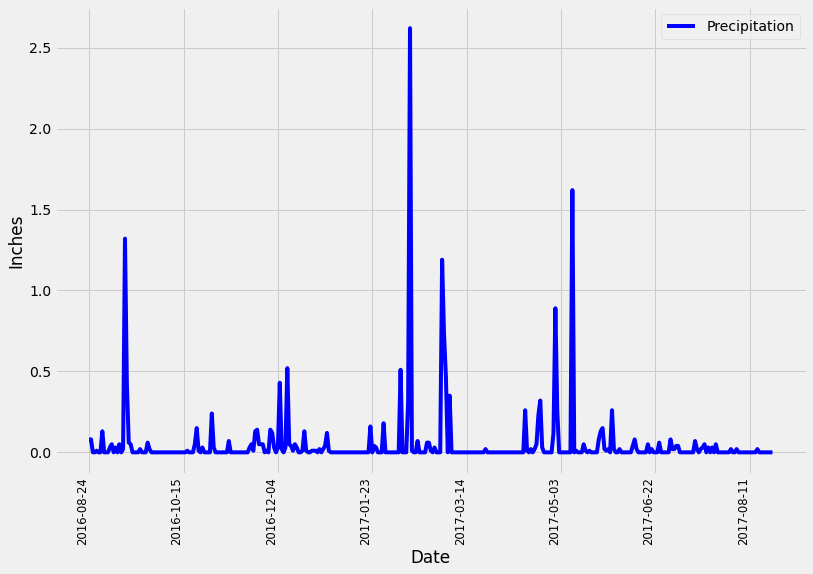

In [17]:
# plotting chart for precipitation

measure_df.plot('Date','Precipitation', color='b',figsize=(12,8), legend='Precipitation');

# setting labels
plt.xticks(rotation=90,horizontalalignment='right', fontweight='light', fontsize='small');
plt.ylabel('Inches')
plt.xlabel('Date')

#plt.savefig('Images/precipitation.png')

plt.show()

In [18]:
# max, min precipitation
max_prcp = measure_df.Precipitation.max()
min_prcp = measure_df.Precipitation.min()

print('------------------------------------------------------------------')
print(f' The maximum and minimum precipitation recorded is: {max_prcp} inches, and {min_prcp} inches')
print('------------------------------------------------------------------')

------------------------------------------------------------------
 The maximum and minimum precipitation recorded is: 2.62 inches, and 0.0 inches
------------------------------------------------------------------


In [19]:
# average precipitation by month

by_month_measure_df = measure_df.copy()
by_month_measure_df['Date'] = by_month_measure_df['Date'].apply(lambda x: x[5:7])

avg_by_month_df = by_month_measure_df.groupby('Date').mean()
avg_by_month_df.reset_index(inplace=True)
avg_by_month_df.head()

print('----------------------------------------------------------------------------------')
print(f'The average precipitation [Inches] by month recorded in the dataset is as follows:')
print('----------------------------------------------------------------------------------')
for row in avg_by_month_df.iterrows():
    print(f'   {row[1][0]} : {round(row[0:2][1][1],2)}')


----------------------------------------------------------------------------------
The average precipitation [Inches] by month recorded in the dataset is as follows:
----------------------------------------------------------------------------------
   01 : 0.01
   02 : 0.13
   03 : 0.09
   04 : 0.07
   05 : 0.09
   06 : 0.01
   07 : 0.01
   08 : 0.01
   09 : 0.08
   10 : 0.02
   11 : 0.02
   12 : 0.06


### Station Analysis

In [20]:
# Design a query to show how many stations are available in this dataset?

station_counts = session.query(Station.station).count()
stations_name = session.query(Measurement.station).distinct().all()

print('-------------------------------------------------')
print(f' There are {station_counts} stations available in the dataset.')
print('-------------------------------------------------')

stations_name

-------------------------------------------------
 There are 9 stations available in the dataset.
-------------------------------------------------


[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?

query = ["Select station, count(station) From Measurement Group By station Order By count(station) Desc"]
most_active = engine.execute(*query).fetchone()
print('---------------------------------------------------------------------------------')
print(f'The most active station is {most_active[0]} with total number of measurement is at {most_active[1]}.')
print('---------------------------------------------------------------------------------')

---------------------------------------------------------------------------------
The most active station is USC00519281 with total number of measurement is at 2772.
---------------------------------------------------------------------------------


In [22]:
# List the stations and the counts in descending order.

query = ["Select station, count(station) From Measurement Group By station Order By count(station) Desc"]
station_list = engine.execute(*query).fetchall()
print('---------------------------------------------------------')
print('List the stations and the counts in descending order:')
print('---------------------------------------------------------')
i = 1
for station in station_list:
    print(' ',i,')', station[0],': ', station[1])
    i +=1

---------------------------------------------------------
List the stations and the counts in descending order:
---------------------------------------------------------
  1 ) USC00519281 :  2772
  2 ) USC00519397 :  2724
  3 ) USC00513117 :  2709
  4 ) USC00519523 :  2669
  5 ) USC00516128 :  2612
  6 ) USC00514830 :  2202
  7 ) USC00511918 :  1979
  8 ) USC00517948 :  1372
  9 ) USC00518838 :  511


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

sel_station = 'USC00519281'
lowest_temp = session.query(func.min(Measurement.tobs)).\
                                filter(Measurement.station == sel_station).\
                                group_by(Measurement.station)


# highest temperature

highest_temp = session.query(func.max(Measurement.tobs)).\
                                filter(Measurement.station == sel_station).\
                                group_by(Measurement.station)
                        
# avergage temperature

avg_temp = session.query(func.avg(Measurement.tobs)).\
                            filter(Measurement.station == sel_station).\
                            group_by(Measurement.station, Measurement.date)

print('--------------------------------------------------------------------------------')
print(f' Station {sel_station} recorded lowest: {round(lowest_temp[0][0],2)}F,\
 average: {round(avg_temp[0][0],2)}F, and highest: {round(highest_temp[0][0],2)}F')
print('--------------------------------------------------------------------------------')

--------------------------------------------------------------------------------
 Station USC00519281 recorded lowest: 54.0F, average: 70.0F, and highest: 85.0F
--------------------------------------------------------------------------------


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel_station = 'USC00519281'

Sel = [Measurement.date, Measurement.tobs]

sel_station_data = session.query(*Sel).filter(Measurement.date >= one_year_ago).\
                                        filter(Measurement.station == sel_station)

In [25]:
# convert to dataframe
sel_station_df = pd.DataFrame(sel_station_data, columns=['Date', 'Temperature']).sort_values('Date').set_index('Date')
sel_station_df #.reset_index(inplace=True)
sel_station_df.head()

,Temperature
Date,
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
2016-08-28,73.0


<Figure size 720x576 with 0 Axes>

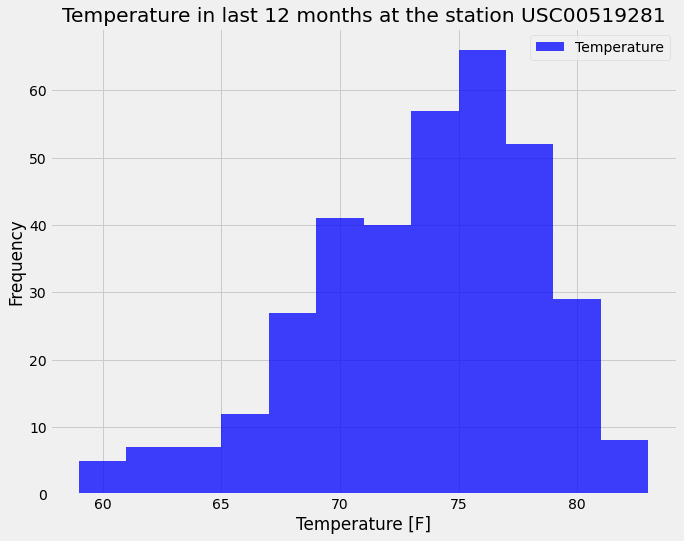

In [26]:
# plotting the results as a histogram

plt.figure(figsize=(10,8));

ax = sel_station_df.plot.hist(bins=12, alpha=0.75, figsize=(10,8), color='b');

# setting labels and title 
plt.ylabel('Frequency')
plt.xlabel('Temperature [F]')
plt.grid(True)
plt.title(f'Temperature in last 12 months at the station {sel_station}')


#plt.savefig('Images/station-histogram.png')
plt.show()

## Bonus: Challenge Assignment

### Temperature Analysis I

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference
  between the temperature in, for example, June and December?

In [27]:
# retrieving average temperature by month across all years
avg_tmp_by_month = session.query(func.strftime("%Y-%m",Measurement.date), func.avg(Measurement.tobs)).\
                    group_by(func.strftime("%Y-%m",Measurement.date))                    

In [28]:
# converting to dataframe
avg_tmp_df = pd.DataFrame(avg_tmp_by_month, columns=['Month', 'Temp'])
avg_tmp_df.head()

,Month,Temp
0,2010-01,69.248756
1,2010-02,67.398876
2,2010-03,69.651982
3,2010-04,71.030973
4,2010-05,73.817073


In [29]:
# re-setting to month format (mm)
avg_tmp_df.Month = avg_tmp_df.Month.apply(lambda x: x[5:7])

In [30]:
# filtering average temperature for the month of June & December
jun_dec_avg_tmp = avg_tmp_df.loc[(avg_tmp_df["Month"] =='06') | (avg_tmp_df["Month"] =='12'),]

In [31]:
jun_dec_avg_tmp.head()

,Month,Temp
5,06,74.925620
11,12,70.208511
17,06,73.938326
23,12,70.820628
29,06,74.000000


• Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
Will you use a paired t-test, or an unpaired t-test? Why?

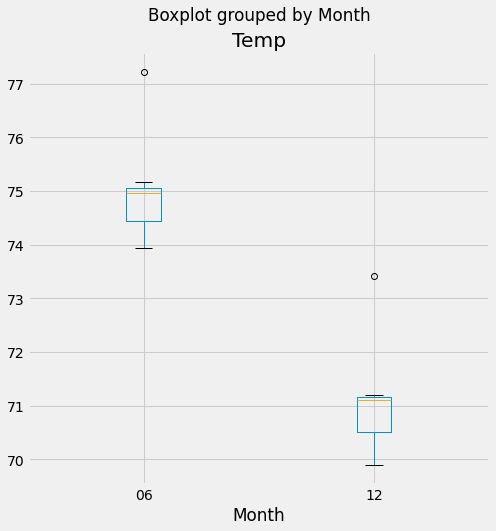

In [32]:
jun_dec_avg_tmp.boxplot("Temp", by="Month", figsize=(8, 8));
plt.show()
#jun_avg_tmp.boxplot("Temp", by="Month", figsize=(10, 8))

In [33]:
jun_avg_tmp = avg_tmp_df.loc[avg_tmp_df["Month"] =='06',]
dec_avg_tmp = avg_tmp_df.loc[avg_tmp_df["Month"] =='12',]

In [34]:
stats.ttest_ind(jun_avg_tmp.Temp, dec_avg_tmp.Temp, equal_var=False)

Ttest_indResult(statistic=6.9218571747346616, pvalue=1.4518830376438732e-05)

### Temperature Analysis II

In [35]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs),1), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.6, 74.0)]


In [36]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# assigning dates for planning trip
arrival_date = "2017-01-12"
departure_date = "2017-01-20"

temp_during_trip = calc_temps(arrival_date, departure_date)
print('---------------------------------------------------------------------------------------------')
print(f'The lowest, average and highest temperature during the period {arrival_date} till {departure_date}:')
print(f'    {temp_during_trip[0][0]:.1f}F,   {temp_during_trip[0][1]:.1f}F  and  {temp_during_trip[0][2]:.1f}F')
print('---------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------
The lowest, average and highest temperature during the period 2017-01-12 till 2017-01-20:
    65.0F,   71.1F  and  81.0F
---------------------------------------------------------------------------------------------


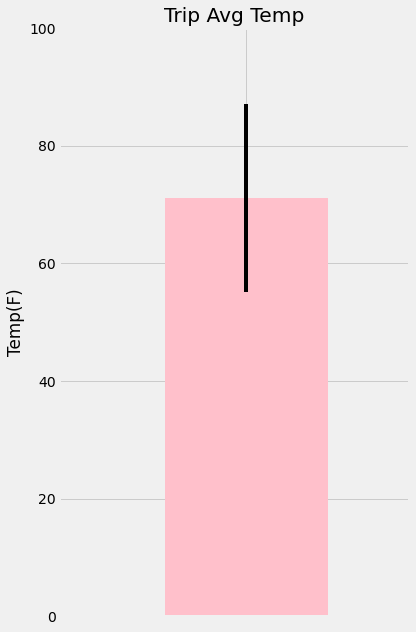

In [37]:
# Plot the results from your previous query as a bar chart.
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(1, 1, figsize=(6,9))
ax.bar([1], temp_during_trip[0][1],  yerr=temp_during_trip[0][2]-temp_during_trip[0][0], width=0.8, color='pink');

# setting range values for x & y axis 
ax.set_xlim(0.08, 1.8)
ax.set_ylim(0, 100)

# Use "Trip Avg Temp" as your Title and set the axis labels
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')

# turning off x ticks labels
plt.xticks([1],(''))

# saving image
#plt.savefig('Images/temperature.png')

# displaying the chart
plt.tight_layout()
plt.show()

### Daily Rainfall Average

In [38]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

Sel = [Measurement.station, Station.name, Station.latitude, \
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

# joining Measurement and Station tables by attribute 'station'
total_rainfall = session.query(*Sel).filter(Measurement.date >= arrival_date).\
                                    filter(Measurement.date <= departure_date).\
                                    filter(Measurement.station == Station.station).\
                                    group_by(Measurement.station, Station.name,\
                                            Station.latitude, Station.longitude, Station.elevation).\
                                    order_by(func.sum(Measurement.prcp).desc()).all()

# verifying the results
total_rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.08),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.03),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

In [39]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.round(func.avg(Measurement.tobs),1), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.2, 77.0)]

In [40]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# assigning dates for planning trip
arrival_date = "2017-01-12"
departure_date = "2017-01-20"

# Set the start and end date of the trip
m_arrival_date =  dt.datetime.strptime(arrival_date, '%Y-%m-%d')
m_departure_date =  dt.datetime.strptime(departure_date, '%Y-%m-%d')

# Use the start and end date to create a range of dates
range_dates = (m_departure_date - m_arrival_date).days + 1

# placing the range of dates into the list in text format
dates_lst = pd.date_range(start=arrival_date, periods=range_dates, freq='D')
dates_lst = dates_lst.astype(str)

# Strip off the year and save a list of %m-%d strings
stped_dates_lst = [x[5:] for x in dates_lst]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals_lst = [daily_normals(day)[0] for day in stped_dates_lst]  
#normals_lst

In [41]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_lst, columns=['tmin', 'tavg', 'tmax'])

# add the `trip_dates` range as the `date` index
normals_df['Date'] = dates_lst

# setting 'date' as index
normals_df = normals_df.set_index('Date')
#normals_df.head()

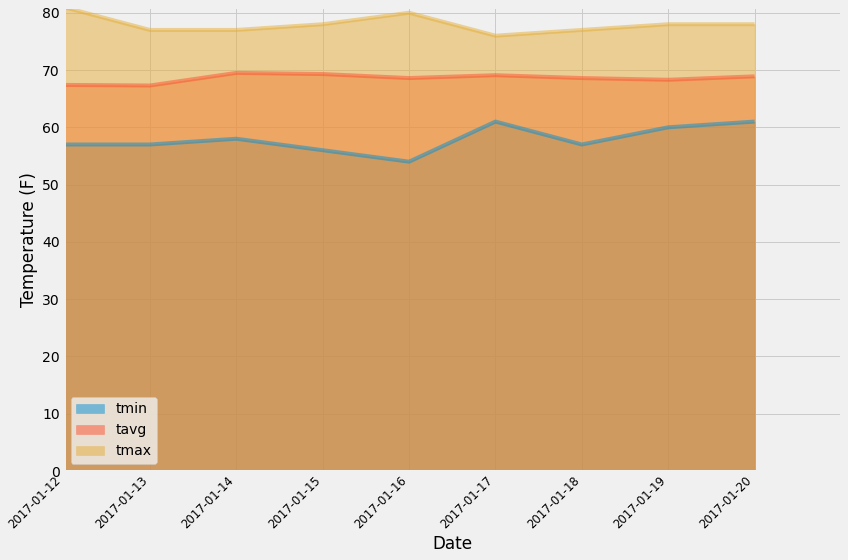

In [42]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False, rot=90, figsize=(12,8));


# setting x ticks, y axis labels
plt.xticks(rotation=45,horizontalalignment='right', fontweight='light', fontsize='small');
plt.ylabel('Temperature (F)')
plt.legend(loc='best')
#plt.xlable('Date')

# setting range for x, y axis
plt.xlim(0, len(normals_df))
plt.ylim(0, max(normals_df['tmax']))

plt.tight_layout()

# saving image to file
#plt.savefig('Images/daily-normals.png')


# displaying the chart
plt.show()
